Setup

In [1]:
!git clone https://github.com/JJGO/UniverSeg
!python -m pip install -r ./UniverSeg/requirements.txt

fatal: destination path 'UniverSeg' already exists and is not an empty directory.


Dependencies

In [2]:
import os
import pandas as pd
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import nibabel as nib
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import random
import math
import itertools
from collections import defaultdict


import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

/home/jonathanlj96/miniforge3/envs/jolje/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jonathanlj96/miniforge3/envs/jolje/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Datasetup og funktioner:

In [3]:
#Set file paths
current_directory = os.environ['HOME']
train_data_path = os.path.join(current_directory, 'mri-infarct-segmentation/data/General_dataset/datasplit/FixedPath/train_data.csv')
val_data_path = os.path.join(current_directory, 'mri-infarct-segmentation/data/General_dataset/datasplit/FixedPath/val_data.csv')
test_data_path = os.path.join(current_directory, 'mri-infarct-segmentation/data/DUPONT/datasplit/FixedPath/test_data.csv')

# Load data
df_train = pd.read_csv(train_data_path)
df_val = pd.read_csv(val_data_path)
df_test = pd.read_csv(test_data_path)

# Data loading function
def load_data(df):
    data = []
    for i in range(len(df)):
        data.append([os.path.join(current_directory, df["DWI_path"][i]),
                     os.path.join(current_directory, df["ADC_path"][i]),
                     os.path.join(current_directory, df["b0"][i]),
                     os.path.join(current_directory, df["Label_path"][i])])
    return data

# Load datasets
train_data = load_data(df_train)
val_data = load_data(df_val)
test_data = load_data(df_test)
support_data = train_data + val_data  # Combine train and validation data for support set


In [4]:
# Define transform function
def transform_slice(slice, target_size=(128, 128)):
    slice = (slice - np.min(slice)) / (np.max(slice) + np.finfo(float).eps)  # Normalize to [0,1]
    slice = Image.fromarray(np.uint8(slice * 255), 'L')
    transform = Compose([
        Resize(target_size),
        ToTensor()
    ])
    return transform(slice)

# Define MRISlicesDataset class
class MRISlicesDataset(Dataset):
    def __init__(self, data_paths, target_size=(128, 128)):
        self.data_paths = data_paths
        self.target_size = target_size
    
    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, idx):
        paths = self.data_paths[idx]
        dwi_vol = nib.load(paths[0]).get_fdata()
        label_vol = nib.load(paths[3]).get_fdata() if len(paths) > 3 else None
        
        num_slices = dwi_vol.shape[2]
        dwi_slices = [transform_slice(dwi_vol[:, :, i], self.target_size) for i in range(num_slices)]
        label_slices = [transform_slice(label_vol[:, :, i], self.target_size) for i in range(num_slices)] if label_vol is not None else None
        
        return dwi_slices, label_slices

Kald datasæt

In [5]:
# Initialize datasets and dataloaders
support_dataset = MRISlicesDataset(support_data)
test_dataset = MRISlicesDataset(test_data)

support_loader = DataLoader(support_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Visualiser random slice og tæl antal af slices

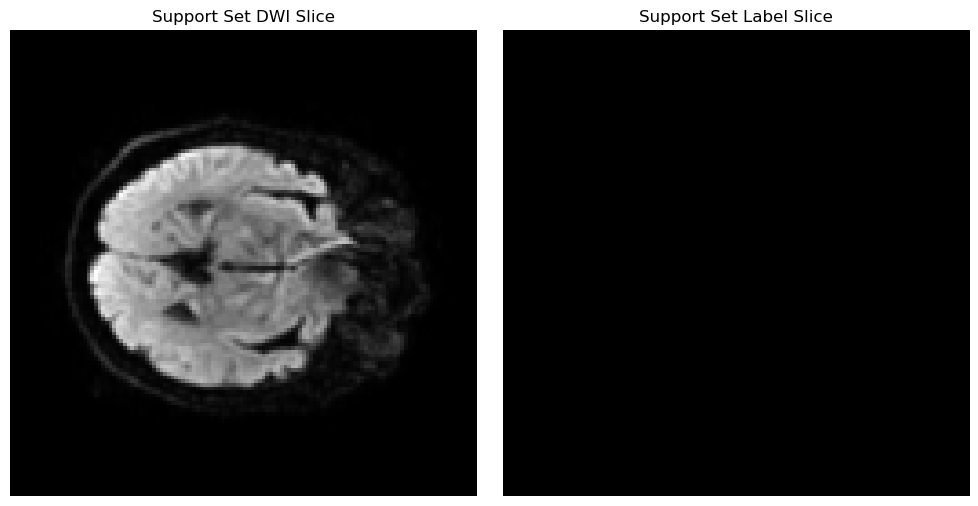

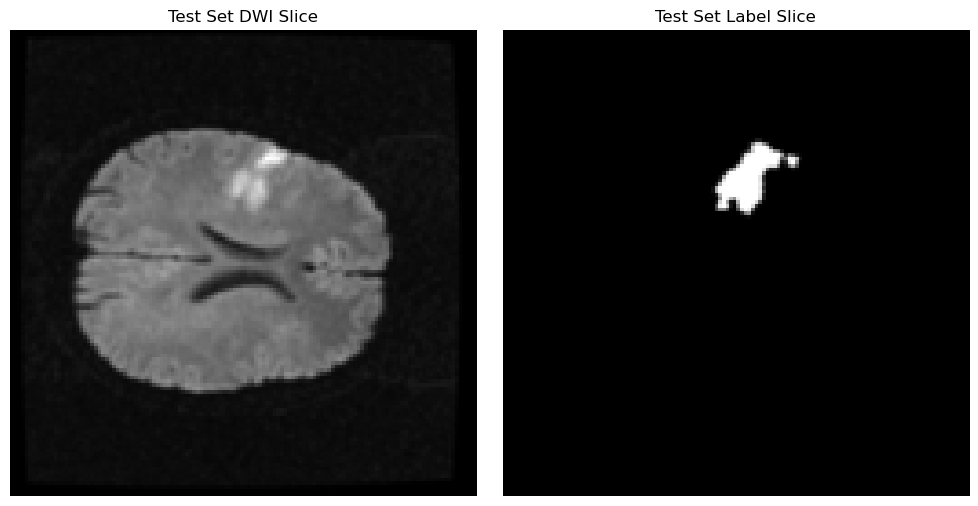

In [6]:
# Helper function to visualize random slice
def visualize_random_slice(dataset, title=""):
    idx = random.randint(0, len(dataset) - 1)
    dwi_slices, label_slices = dataset[idx]
    slice_idx = random.randint(0, len(dwi_slices) - 1)
    dwi_slice = dwi_slices[slice_idx].squeeze().numpy()
    label_slice = label_slices[slice_idx].squeeze().numpy() if label_slices else None

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(dwi_slice, cmap='gray')
    axes[0].set_title(f"{title} DWI Slice")
    axes[0].axis('off')
    if label_slice is not None:
        axes[1].imshow(label_slice, cmap='gray')
        axes[1].set_title(f"{title} Label Slice")
        axes[1].axis('off')
    else:
        axes[1].set_visible(False)
    plt.tight_layout()
    plt.show()

# Visualize a random slice from support and test datasets
visualize_random_slice(support_dataset, title="Support Set")
visualize_random_slice(test_dataset, title="Test Set")

In [7]:
# Count slices in dataset
def count_slices_in_dataset(dataset):
    total_slices = 0
    for i in range(len(dataset)):
        dwi_slices, label_slices = dataset[i]
        total_slices += len(dwi_slices)
    return total_slices

# Count number of slices in support and test sets
num_slices_in_support_set = count_slices_in_dataset(support_dataset)
num_slices_in_test_set = count_slices_in_dataset(test_dataset)

print(f"Number of slices in support set: {num_slices_in_support_set}")
print(f"Number of slices in test set: {num_slices_in_test_set}")

Number of slices in support set: 4367
Number of slices in test set: 177


Forbered tensors

In [8]:
# Prepare support set tensors (only slices with infarcts)
support_images = []
support_labels = []

# Collect all support images and labels with infarcts
for dwi_slices, label_slices in support_loader:
    for dwi_slice, label_slice in zip(dwi_slices, label_slices):
        if label_slice.sum() > 0:  # Only add slices with infarcts
            support_images.append(dwi_slice)
            support_labels.append(label_slice)


In [9]:
# Prepare support set tensors (only slices with infarcts)
support_images = []
support_labels = []

# Collect all support images and labels with infarcts
for dwi_slices, label_slices in support_loader:
    for dwi_slice, label_slice in zip(dwi_slices, label_slices):
        if label_slice.sum() > 0:  # Only add slices with infarcts
            support_images.append(dwi_slice)
            support_labels.append(label_slice)

# Convert to tensors and adjust dimensions
support_images = torch.stack(support_images).squeeze(1).to(device)  # Add channel dimension
support_labels = torch.stack(support_labels).squeeze(1).to(device)

# Prepare test set
test_samples = [test_dataset[i] for i in range(len(test_dataset))]
test_images, test_labels = zip(*test_samples)
flattened_test_images = [slice for slices in test_images for slice in slices]
flattened_test_labels = [label for labels in test_labels for label in labels]

# Convert to tensors
test_images_tensor = torch.stack(flattened_test_images).to(device)
test_labels_tensor = torch.stack(flattened_test_labels).to(device)

print(f"Support images tensor shape: {support_images.shape}")
print(f"Support labels tensor shape: {support_labels.shape}")

print(f"Test images tensor shape: {test_images_tensor.shape}")
print(f"Test labels tensor shape: {test_labels_tensor.shape}")

Support images tensor shape: torch.Size([1245, 1, 128, 128])
Support labels tensor shape: torch.Size([1245, 1, 128, 128])
Test images tensor shape: torch.Size([177, 1, 128, 128])
Test labels tensor shape: torch.Size([177, 1, 128, 128])


Funktioner til evaluering

In [10]:
# Prepare support set tensors (only slices with infarcts)
support_images = []
support_labels = []

# Collect all support images and labels with infarcts
for dwi_slices, label_slices in support_loader:
    for dwi_slice, label_slice in zip(dwi_slices, label_slices):
        if label_slice.sum() > 0:  # Only add slices with infarcts
            support_images.append(dwi_slice)
            support_labels.append(label_slice)

# Convert to tensors and adjust dimensions
support_images = torch.stack(support_images).squeeze(1).to(device)  # Add channel dimension
support_labels = torch.stack(support_labels).squeeze(1).to(device)

# Prepare test set
test_samples = [test_dataset[i] for i in range(len(test_dataset))]
test_images, test_labels = zip(*test_samples)
flattened_test_images = [slice for slices in test_images for slice in slices]
flattened_test_labels = [label for labels in test_labels for label in labels]

# Convert to tensors
test_images_tensor = torch.stack(flattened_test_images).to(device)
test_labels_tensor = torch.stack(flattened_test_labels).to(device)

print(f"Support images tensor shape: {support_images.shape}")
print(f"Support labels tensor shape: {support_labels.shape}")

print(f"Test images tensor shape: {test_images_tensor.shape}")
print(f"Test labels tensor shape: {test_labels_tensor.shape}")

model = model.eval()

# Dice score function
def dice_score(pred, target, threshold=0.5):
    target = (target > threshold).float()
    if pred.sum() == 0 and target.sum() == 0:
        return None  # Return None if both predictions and targets are all zeros
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum())

Support images tensor shape: torch.Size([1245, 1, 128, 128])
Support labels tensor shape: torch.Size([1245, 1, 128, 128])
Test images tensor shape: torch.Size([177, 1, 128, 128])
Test labels tensor shape: torch.Size([177, 1, 128, 128])


Inference

In [11]:
# Inference function
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # Inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0]  # Outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0, 1)

    # Score
    score = dice_score(hard_pred, label)

    # Return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

# Function to analyze a single subject
def analyze_subject(subject_idx, orig_support_images=None, orig_support_labels=None):
    global support_images, support_labels
    dwi_slices, label_slices = test_dataset[subject_idx]
    
    # Reset support set to original
    support_images = orig_support_images.clone()
    support_labels = orig_support_labels.clone()
    
    # Initialize results dictionary
    results = defaultdict(list)
    
    # Segment all slices for the subject
    for j in range(len(dwi_slices)):
        vals = inference(model, dwi_slices[j], label_slices[j], support_images, support_labels)
        for k, v in vals.items():
            results[k].append(v)
    
    # Calculate average dice scores for the subject
    subject_dice_scores = [score for score in results['score'] if score is not None]
    avg_subject_dice = sum(subject_dice_scores) / len(subject_dice_scores) if subject_dice_scores else None
    
    # Calculate dice score for the whole volume for the subject
    preds = torch.cat(results['Prediction'])
    labels = torch.cat(results['Ground Truth'])
    volume_dice_score = dice_score(preds, labels)
    
    return results, avg_subject_dice, volume_dice_score, subject_dice_scores

# Store original support set
orig_support_images = support_images.clone()
orig_support_labels = support_labels.clone()

# List to store subject dice scores and volumes
subject_dice_scores = []
subject_dice_volumes = []
all_subject_slice_scores = []

# Analyze each subject and store the results
for i in range(len(test_dataset)):
    results, avg_subject_dice, volume_dice_score, slice_scores = analyze_subject(i, orig_support_images=orig_support_images, orig_support_labels=orig_support_labels)
    subject_dice_scores.append(avg_subject_dice)
    subject_dice_volumes.append(volume_dice_score)
    all_subject_slice_scores.append(slice_scores)
    print(f"Subject {i+1}:")
    print(f"  Average Dice score per slice: {avg_subject_dice if avg_subject_dice is not None else 'N/A'}")
    print(f"  Dice score for the whole volume: {volume_dice_score if volume_dice_score is not None else 'N/A'}")


Subject 1:
  Average Dice score per slice: 0.2719896137714386
  Dice score for the whole volume: 0.6257554888725281
Subject 2:
  Average Dice score per slice: 0.0
  Dice score for the whole volume: 0.0
Subject 3:
  Average Dice score per slice: 0.24140024185180664
  Dice score for the whole volume: 0.46692606806755066
Subject 4:
  Average Dice score per slice: 0.340055376291275
  Dice score for the whole volume: 0.6473429799079895
Subject 5:
  Average Dice score per slice: 0.07426470518112183
  Dice score for the whole volume: 0.018726591020822525
Subject 6:
  Average Dice score per slice: 0.1979954093694687
  Dice score for the whole volume: 0.5783397555351257
Subject 7:
  Average Dice score per slice: 0.06977273523807526
  Dice score for the whole volume: 0.03418803587555885
Subject 8:
  Average Dice score per slice: 0.30587026476860046
  Dice score for the whole volume: 0.618146538734436


In [14]:
# Print the average Dice score for slices and volumes
print(f"Average Dice score for slices: {np.mean(subject_dice_scores)}")
print(f"Average Dice score for volumes: {np.mean(subject_dice_volumes)}")

Average Dice score for slices: 0.18766853213310242
Average Dice score for volumes: 0.37367817759513855


Boxplot

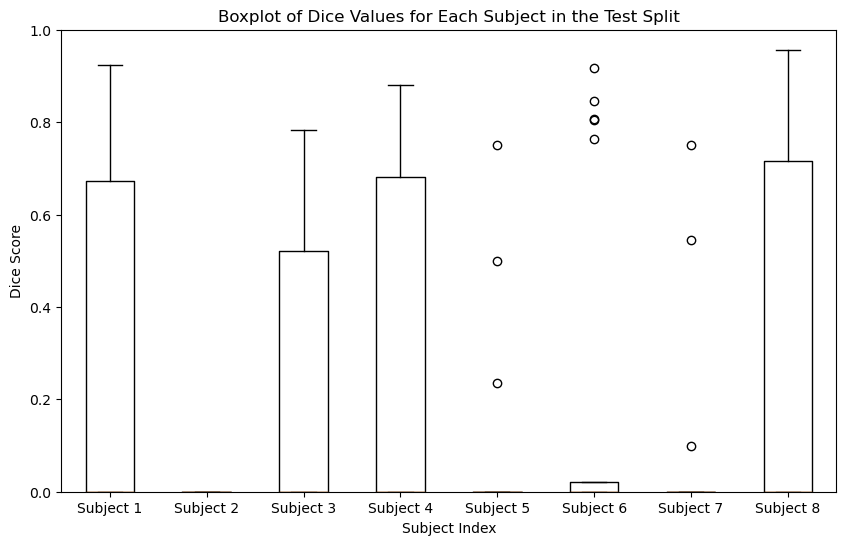

In [15]:
def visualize_boxplot(scores_by_subject, title="Boxplot of Dice Values for Each Subject"):
    """Visualize a boxplot of the Dice scores for each subject."""
    plt.figure(figsize=(10, 6))

    # Create the boxplot
    plt.boxplot(scores_by_subject)

    # Adding titles and labels
    plt.title(title)
    plt.xlabel('Subject Index')
    plt.ylabel('Dice Score')

    # Customize x-axis labels
    subject_labels = [f'Subject {i+1}' for i in range(len(scores_by_subject))]
    plt.xticks(range(1, len(scores_by_subject) + 1), subject_labels)

    # Set y-axis limits
    plt.ylim(0, 1)

    # Show the plot
    plt.show()

# Visualize the boxplot
visualize_boxplot(all_subject_slice_scores, title="Boxplot of Dice Values for Each Subject in the Test Split")